# TAESDXL Training

This notebook demonstrates how to train a tiny encoder / decoder for the SDXL latent space.

## Config

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

import glob
import random
from collections import namedtuple
from functools import lru_cache
from pathlib import Path

import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from PIL import Image
from tqdm import tqdm

th.backends.cudnn.benchmark = True

In [2]:
class Config:
    # Train the encoder?
    train_encoder = True
    # Train the decoder?
    train_decoder = True

    # Dataset folder to search for images in
    # dataset_path = "dataset"
    dataset_path = (
        "/code/comfyui_sandbox/video_renders/render_nfs_4screens_5_sdxl_1_wan_mix"
    )

    # Height / width of patches used for training (always need to finetune on 256x256 at the end)
    hw = 96
    # Number of patches to show in visualizations
    n_demo = 1024 // hw

    # Device and dtype to use for reference model
    device = "cuda"
    ref_dtype = th.float16

    # dtype to use for trained model
    dtype = th.float32

In [3]:
1024 // 96

10

## Dataset

The dataset code will load images from the dataset folder and crop out random patches.

In [4]:
def show(x):
    if not isinstance(x, th.Tensor) or x.ndim == 4:
        x = th.cat(tuple(x), -1)
    display(TF.to_pil_image(x))


def show_latents(x):
    show(F.interpolate(x[:, :3].add(0.5).mul_(0.3).clamp_(0, 1), scale_factor=8))


def random_resize_crop(im, patch_hw):
    # pad as needed in case there are tiny images
    if min(im.size) < patch_hw:
        px = patch_hw - im.width
        py = patch_hw - im.height
        im = TF.pad(
            im, (px // 2, px - px // 2, py // 2, py - py // 2), padding_mode="reflect"
        )
    crop_hw = random.randint(patch_hw, max(patch_hw, min(im.size)))
    crop_x = random.randrange(0, im.width - crop_hw) if im.width > crop_hw else 0
    crop_y = random.randrange(0, im.height - crop_hw) if im.height > crop_hw else 0
    patch = im.crop((crop_x, crop_y, crop_x + crop_hw, crop_y + crop_hw))
    return patch.resize((patch_hw, patch_hw), Image.BICUBIC)


class Dataset(th.utils.data.Dataset):
    def __init__(self, p, patch_hw, image_extensions=["jpg", "png"]):
        # no pathlib glob here, pathlib glob is bad with symlinks and hidden files
        self.ims = sum(
            [glob.glob(p + f"/**/*.{ext}", recursive=True) for ext in image_extensions],
            [],
        )
        self.patch_hw = patch_hw

    def __len__(self):
        return len(self.ims)

    def __getitem__(self, i):
        im = Image.open(self.ims[i])
        im = random_resize_crop(im, self.patch_hw)
        im = im.convert("RGB")
        im = TF.pil_to_tensor(im)
        return im


d_train = Dataset(Config.dataset_path, Config.hw)
print(f"Got {len(d_train)} images from {Config.dataset_path}")

Got 848 images from /code/comfyui_sandbox/video_renders/render_nfs_4screens_5_sdxl_1_wan_mix


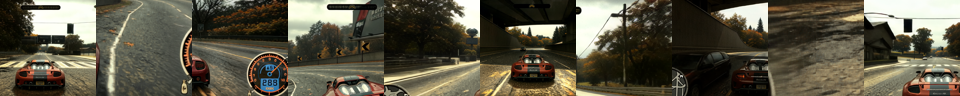

In [5]:
def demo_cpu_dataset(dataset):
    show(random.choice(dataset) for _ in range(Config.n_demo))


demo_cpu_dataset(d_train)

## SDXL Encoder

The reference SDXL VAE will be used to convert patches into latents.

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.9.0+cu130 with CUDA 1300 (you have 2.9.0+cu128)
    Python  3.10.19 (you have 3.11.14)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Original Images


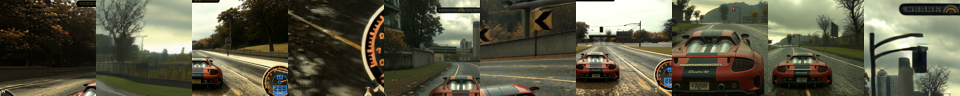

Latents


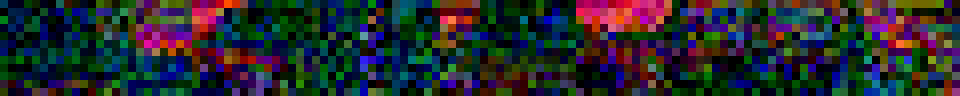

Decoded Images


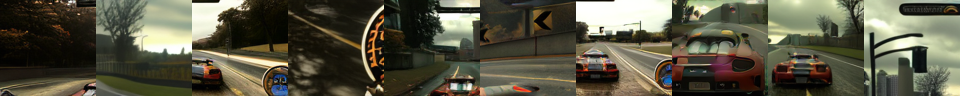

In [6]:
class DiffusersVAEWrapper:
    def __init__(self):
        from diffusers import AutoencoderKL

        self.vae = (
            AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix")
            .to(device=Config.device, dtype=Config.ref_dtype)
            .eval()
            .requires_grad_(False)
        )
        self.sf = self.vae.config.scaling_factor

    def encode(self, x):
        return (
            self.vae.encode(
                x.to(device=Config.device, dtype=Config.ref_dtype).mul(2).sub_(1)
            )
            .latent_dist.sample()
            .mul_(self.sf)
            .to(device=x.device, dtype=x.dtype)
        )

    def decode(self, x):
        return (
            self.vae.decode(
                x.to(device=Config.device, dtype=Config.ref_dtype).div(self.sf)
            )
            .sample.mul_(0.5)
            .add_(0.5)
            .clamp_(0, 1)
            .to(device=x.device, dtype=x.dtype)
        )


vae_ref = DiffusersVAEWrapper()


def demo_vae_wrapper(dataset, vae):
    ims = (
        th.stack([random.choice(dataset) for _ in range(Config.n_demo)], 0)
        .to(device=Config.device, dtype=Config.ref_dtype)
        .div_(255.0)
    )
    print("Original Images")
    show(ims)

    print("Latents")
    latents = vae.encode(ims)
    show_latents(latents)

    print("Decoded Images")
    show(vae.decode(latents))


demo_vae_wrapper(d_train, vae_ref)

In [7]:
Sample = namedtuple("Sample", ("im", "latent"))


def gpu_preprocess(ims):
    ims = ims.to(device=Config.device, dtype=Config.ref_dtype).div_(255.0)
    latent = vae_ref.encode(ims)
    return Sample(ims.to(Config.dtype), latent.to(Config.dtype))

## TAESDXL Model

Our TAESDXL model will be trained to convert SDXL latents to and from RGB images.
We'll also load a pretrained TAESDXL model for reference.

In [8]:
!wget -nc -q https://raw.githubusercontent.com/madebyollin/taesd/main/taesd.py
!wget -nc -q https://raw.githubusercontent.com/madebyollin/taesd/main/taesdxl_encoder.pth
!wget -nc -q https://raw.githubusercontent.com/madebyollin/taesd/main/taesdxl_decoder.pth

In [ ]:
from auto_remaster.sandbox.seraena.taesd import TAESD


def count_params(label, m):
    n_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
    n_params_str = f"{n_params/1e6:.2f}M"
    return f"{label.ljust(16)}{n_params_str.rjust(8)} params"


model = TAESD(encoder_path=None, decoder_path=None).to(
    device=Config.device, dtype=Config.dtype
)
nn.init.constant_(model.decoder[-1].bias, 0.5)

print(count_params("model", model))
print(count_params(".encoder", model.encoder))
print(count_params(".decoder", model.decoder))


def weight_average(w_prev, w_new, n):
    alpha = min(0.95, n / 10)
    # n могу ошибаться но кажется это количество копий сколько мы держим
    # то есть после 10 вызовов эта штука станет больше 1, и у нас все время будет 0.95?
    # 0.95
    return alpha * w_prev + (1 - alpha) * w_new


avg_model = th.optim.swa_utils.AveragedModel(model, avg_fn=weight_average)

model              2.45M params
.encoder           1.22M params
.decoder           1.22M params


In [10]:
pretrained_model = TAESD(
    encoder_path="taesdxl_encoder.pth", decoder_path="taesdxl_decoder.pth"
)
pretrained_model = (
    pretrained_model.to(device=Config.device, dtype=Config.dtype)
    .eval()
    .requires_grad_(False)
)

Latents (Reference Encoder)


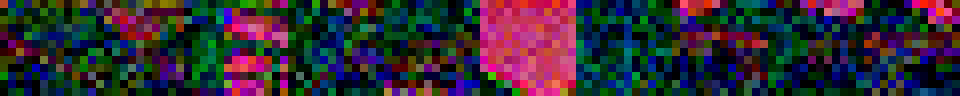

Latents (Pretrained Encoder)


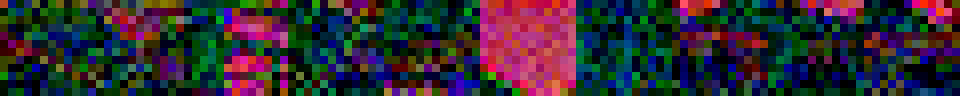

Latents (Our Encoder)


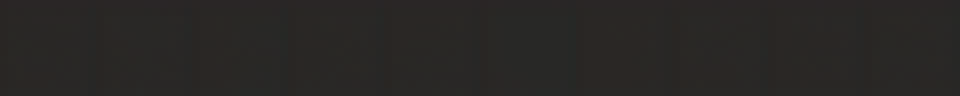

Decoded Images (Reference Decoder)


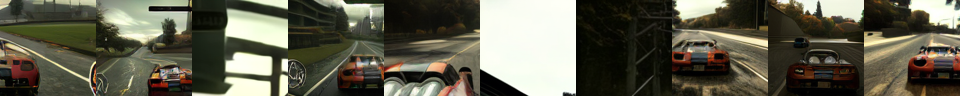

Decoded Images (Pretrained Decoder)


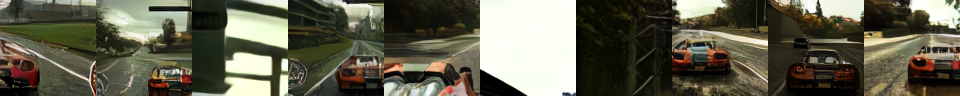

Decoded Images (Our Decoder)


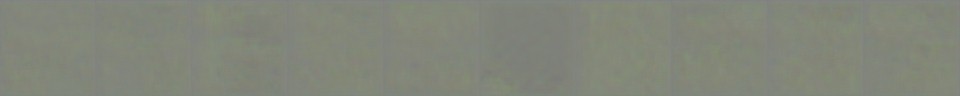

Original Images


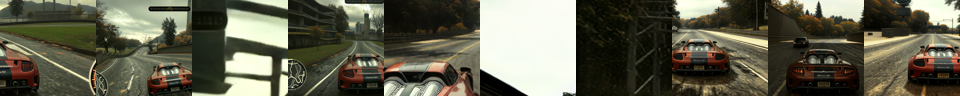

In [11]:
@th.no_grad()
def demo_taesd(xb, model, n=Config.n_demo):
    print("Latents (Reference Encoder)")
    show_latents(xb.latent[:n])

    print("Latents (Pretrained Encoder)")
    show_latents(pretrained_model.encoder(xb.im[:n]))

    print("Latents (Our Encoder)")
    show_latents(model.encoder(xb.im[:n]))

    print("Decoded Images (Reference Decoder)")
    show(vae_ref.decode(xb.latent[:n]))

    print("Decoded Images (Pretrained Decoder)")
    show(pretrained_model.decoder(xb.latent[:n]).clamp_(0, 1))

    print("Decoded Images (Our Decoder)")
    show(model.decoder(xb.latent[:n]).clamp_(0, 1))

    print("Original Images")
    show(xb.im[:n])


demo_taesd(
    gpu_preprocess(
        next(
            iter(
                th.utils.data.DataLoader(
                    d_train, batch_size=Config.n_demo, shuffle=True
                )
            )
        )
    ),
    avg_model.module,
)

## Seraena

Seraena will be used to generate the training guidance for our decoder model.

In [13]:
from auto_remaster.sandbox.seraena.seraena import Seraena

seraena = Seraena(3, 4).to(Config.device)
print(count_params("seraena", seraena))

seraena            7.48M params


/code/auto_remaster/sandbox/seraena/seraena.py:76: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = th.cuda.amp.GradScaler(enabled=use_amp)


## Training Loop

In [ ]:
import datetime
import os
import time

from IPython.display import clear_output


class Visualizer:
    def __init__(self):
        self.losses_since_last_vis = []
        self.avg_losses = []
        self.steps = []
        self.step = 0
        self.t_last_vis = 0
        self.t_last_save = 0
        self.t_start = None
        folder, idx = (
            datetime.datetime.now().strftime("%Y_%m_%d")
            + "_taesdxl_example_training_logs",
            0,
        )
        while Path(f"{folder}_{idx}").exists():
            idx += 1
        self.folder = Path(f"{folder}_{idx}")
        self.folder.mkdir()

    @th.no_grad()
    def __call__(
        self,
        model,
        seraena,
        t,
        debug,
        losses,
        n_demo=Config.n_demo,
        visualize=False,
    ):
        self.losses_since_last_vis.append(sum(losses.values()).item())
        avg_loss = sum(self.losses_since_last_vis) / len(self.losses_since_last_vis)
        self.step += 1
        if self.t_start is None:
            self.t_start = t
        if visualize:
            clear_output(wait=True)
            disc_idx = th.randperm(len(debug["disc_in"]))[:n_demo]
            print("Seraena Input Images / Latents")
            show(debug["disc_in"][disc_idx].clamp(0, 1))
            show_latents(debug["disc_in_ctx"][disc_idx])
            print("Seraena Predictions")
            show(
                F.interpolate(
                    debug["disc_pred"][disc_idx].mean(1, keepdim=True),
                    debug["xb"].im.shape[-2:],
                ).clamp(0, 1)
            )
            print("Seraena Targets")
            show(
                F.interpolate(
                    debug["disc_targets"][disc_idx].mean(1, keepdim=True),
                    debug["xb"].im.shape[-2:],
                ).clamp(0, 1)
            )
            print(f"Seraena Loss: {debug['disc_loss']:.5f}")

            demo_taesd(debug["xb"], model)
            if Config.train_decoder:
                print("Total Decoder Corrections (negative grad)")
                show((debug["decoder_grad"])[:n_demo].neg().add(0.5).clamp(0, 1))

            self.steps.append(self.step)
            self.avg_losses.append(avg_loss)
            self.losses_since_last_vis = []
            plt.title("Losses")
            plt.plot(
                self.steps,
                self.avg_losses,
                label=f"{self.folder} {self.avg_losses[-1]:.5f}",
            )
            plt.gcf().set_size_inches(16, 4)
            plt.ylim(0, 1.5 * self.avg_losses[-1])
            plt.legend()
            if t > self.t_last_save + 120:
                th.save(model.state_dict(), self.folder / "model.pth")
                th.save(seraena.state_dict(), trainer.visualizer.folder / "seraena.pth")
                th.save((self.steps, self.avg_losses), self.folder / "stats.pth")
                plt.gcf().savefig(self.folder / "stats.jpg")
                self.t_last_save = t
            plt.show()
            self.t_last_vis = t
        print(
            f"\r{self.step: 5d} Steps; {int(t - self.t_start): 3d} Seconds; "
            f"{60 * self.step / (t - self.t_start + 1):.1f} Steps / Min; "
            f"{len(debug['xb'].im) * 60 * self.step / (t - self.t_start + 1):.1f} Images / Min; "
            f"Loss {avg_loss:.5f}",
            end="",
        )


class Trainer:
    def __init__(self, dataset, model, avg_model, seraena, batch_size=32):
        self.model = model
        self.avg_model = avg_model
        self.last_avg_time = time.time()
        self.optimizer = th.optim.AdamW(model.parameters(), 3e-5, betas=(0.9, 0.99))
        num_workers = min(
            12,
            (
                len(os.sched_getaffinity(0))
                if hasattr(os, "sched_getaffinity")
                else os.cpu_count()
            ),
        )
        self.dataloader = th.utils.data.DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True,
            num_workers=num_workers,
        )
        self.scaler = th.cuda.amp.GradScaler()
        self.dl_iter = iter(self.dataloader)
        self.seraena = seraena
        self.visualizer = Visualizer()
        self.n_steps = 0

    def avg_model_step(self, t):
        if t > self.last_avg_time + 2:
            self.avg_model.update_parameters(self.model)
            self.last_avg_time = t

    def get_batch(self):
        try:
            batch = next(self.dl_iter)
        except StopIteration:
            self.dl_iter = iter(self.dataloader)
            batch = next(self.dl_iter)
        # тут мы стандартно забираем картинку, затем на лету кодируем ее
        # в функции gpu_preprocess, получаются писксели и латенты идущие рядом
        return gpu_preprocess(batch)

    def train(self, n_seconds):
        self.model.train()
        start_time = time.time()
        while time.time() < start_time + n_seconds:
            self.train_step(time.time())

    def train_step(self, t):
        train_batch = self.get_batch()

        debug = {"xb": train_batch}
        losses = {}

        if Config.train_encoder:
            with th.cuda.amp.autocast():
                # кодируем картинку при помощи энкодера, который обучаем
                encoded = self.model.encoder(train_batch.im)
                # считаем лосс между латентом из оригинального и обучаемого
                losses["encoder"] = F.mse_loss(encoded, train_batch.latent)
                debug["encoded"] = encoded.detach()

        if Config.train_decoder:
            # создаем пустую фейкувую коррекцию с обучением
            # это нужно только чтобы на отладке посмотреть куда направлен градиент
            # Создаем "шпионский" тензор из нулей. Он не меняет результат (так как +0),
            # но позволяет перехватить протекающие через него градиенты (dL/dImage)
            # во время backward(). Это нужно исключительно для визуализации тепловой
            # карты ошибок в отчетах, на веса модели это не влияет.
            decoder_grad = th.zeros_like(train_batch.im).requires_grad_(True)
            with th.cuda.amp.autocast():
                # декодируем оригинальные латенты обучаемым декодером и добавляем к ним
                # обучаемый массив
                decoded = self.model.decoder(train_batch.latent) + decoder_grad
            # совершаем шаг при помощи saraena
            target, seraena_debug = self.seraena.step_and_make_correction_targets(
                real=train_batch.im,
                fake=decoded,
                ctx=train_batch.latent,
            )
            debug.update(seraena_debug)
            debug["target"] = target
            with th.cuda.amp.autocast():
                # разница между выходом модели и декодера
                losses["decoder"] = F.mse_loss(decoded, target)
                debug["decoded"] = decoded.detach()

        self.optimizer.zero_grad()
        self.scaler.scale(sum(losses.values())).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()
        self.avg_model_step(t)
		# важно откреплять такие тензоры, если мы собираемся их хранить
		# так как это легко может привести к OOM
        debug["decoder_grad"] = decoder_grad.grad.detach()
        self.visualizer(
            self.avg_model.module,
            self.seraena,
            t,
            debug,
            losses,
            visualize=(t > self.visualizer.t_last_vis + 30),
        )
        self.n_steps += 1


trainer = Trainer(d_train, model, avg_model, seraena)

/tmp/ipykernel_1444861/1772733007.py:120: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = th.cuda.amp.GradScaler()


In [ ]:
"""

### Алгоритм шага обучения (Train Step)

**1. Входные данные**
Получение батча данных из датасета. Батч содержит пары:
*   `real`: Реальные изображения (Ground Truth).
*   `ctx`: Идеальные латентные коды (сжатое представление этих изображений).

**2. Обучение Энкодера (Сжатие)**
*   Прогон реального изображения через обучаемый энкодер: `encoded = model.encoder(real)`.
*   Расчет функции потерь энкодера: MSE между предсказанным латентом (`encoded`) и идеальным (`ctx`).

**3. Генерация (Черновой проход Декодера)**
*   Создание вспомогательного нулевого тензора-шпиона: `spy_zeros` (requires_grad=True). 
	Это нужно исключительно для отладки и последующей визуализации того, как Seraena меняет пиксели. 
 	В математику обучения этот тензор вклад не вносит (так как равен нулю).
*   Генерация чернового изображения: `fake = model.decoder(ctx) + spy_zeros`.
*   На этом этапе `fake` — это "сырой" результат работы текущей версии декодера.

**4. Этап Seraena (Состязательная коррекция)**
Вызывается метод `step_and_make_correction_targets`, который внутри выполняет два под-этапа:

*   **А. Тренировка Дискриминатора:**
    *   Формируется обучающая выборка для дискриминатора, состоящая на 50% из текущих фейков и на 50% 
    	из исторических фейков (Experience Replay Buffer). Это предотвращает "катастрофическое забывание" 
     	и переобучение под текущие ошибки генератора.
    *   Реальные и фейковые изображения перемешиваются (Batch Mixing) для корректной работы BatchNorm.
    *   Дискриминатор обучается различать их, используя функцию потерь **LSGAN** (Least Squares GAN), минимизируя 
    	квадратичную ошибку предсказаний. Происходит обновление весов дискриминатора.

*   **Б. Вычисление Коррекции (Target Creation):**
    *   Веса дискриминатора замораживаются.
    *   Сравниваются внутренние признаки (feature maps) реального изображения и фейкового.
    *   Методом обратного распространения ошибки (backpropagation) вычисляется **коррекция**, при помощи взятия 
    негативного градиента — аддитивный шум для 
    	пикселей `fake`, который заставляет дискриминатор считать изображение реальным (Feature Matching).
    *   Формируется целевое изображение: `target = fake + correction`.

**5. Обучение Декодера (Реконструкция)**
*   Рассчитывается функция потерь декодера как MSE между его "сырым" выходом (`fake`) и "исправленной целью" (`target`).
*   Декодер учится сразу генерировать изображение, к которому его подталкивает Seraena.

**6. Оптимизация и Пост-обработка**
*   Суммирование ошибок (Энкодер + Декодер).
*   **Backward:** Расчет градиентов для всех весов модели. В этот момент тензор-шпион (`spy_zeros`) перехватывает 
	градиенты исправлений для визуализации.
*   **Step:** Оптимизатор обновляет веса нейросети.
*   **EMA (Exponential Moving Average):** Обновление весов усредненной модели (Avg Model) для стабильности инференса 
	(обычно по формуле $W_{ema} = \beta W_{ema} + (1-\beta) W_{new}$).
"""

Seraena Input Images / Latents


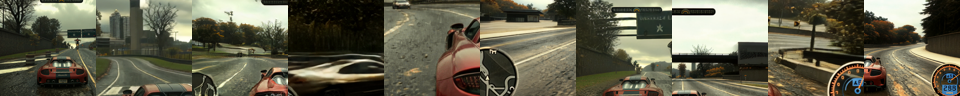

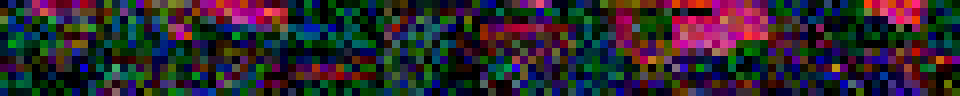

Seraena Predictions


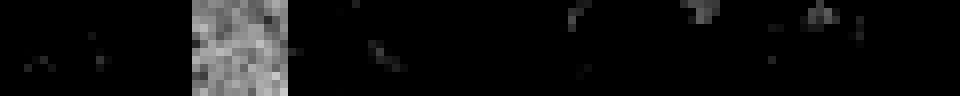

Seraena Targets


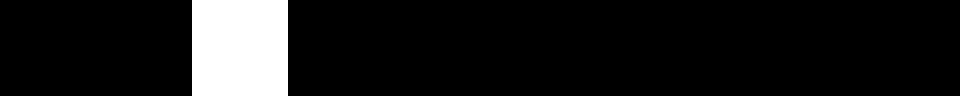

Seraena Loss: 0.59361
Latents (Reference Encoder)


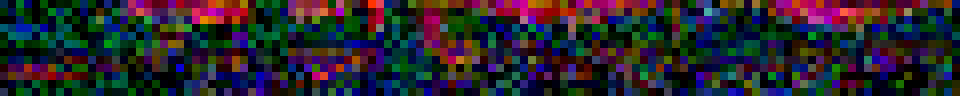

Latents (Pretrained Encoder)


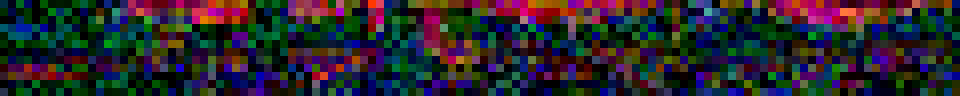

Latents (Our Encoder)


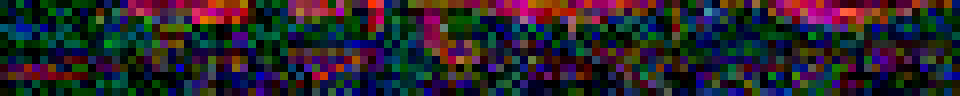

Decoded Images (Reference Decoder)


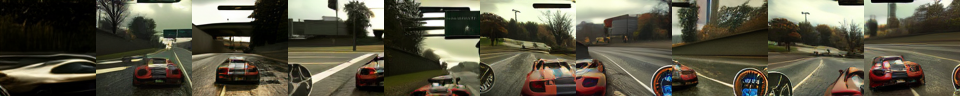

Decoded Images (Pretrained Decoder)


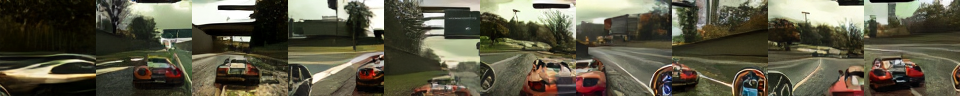

Decoded Images (Our Decoder)


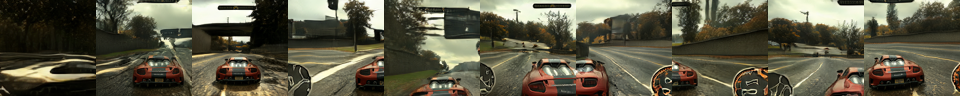

Original Images


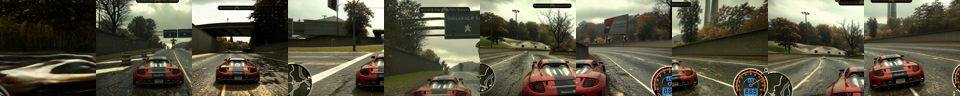

Total Decoder Corrections (negative grad)


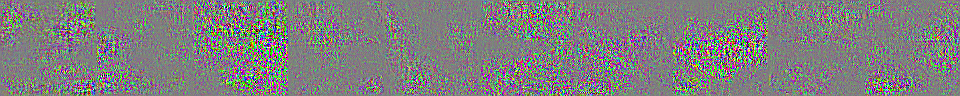

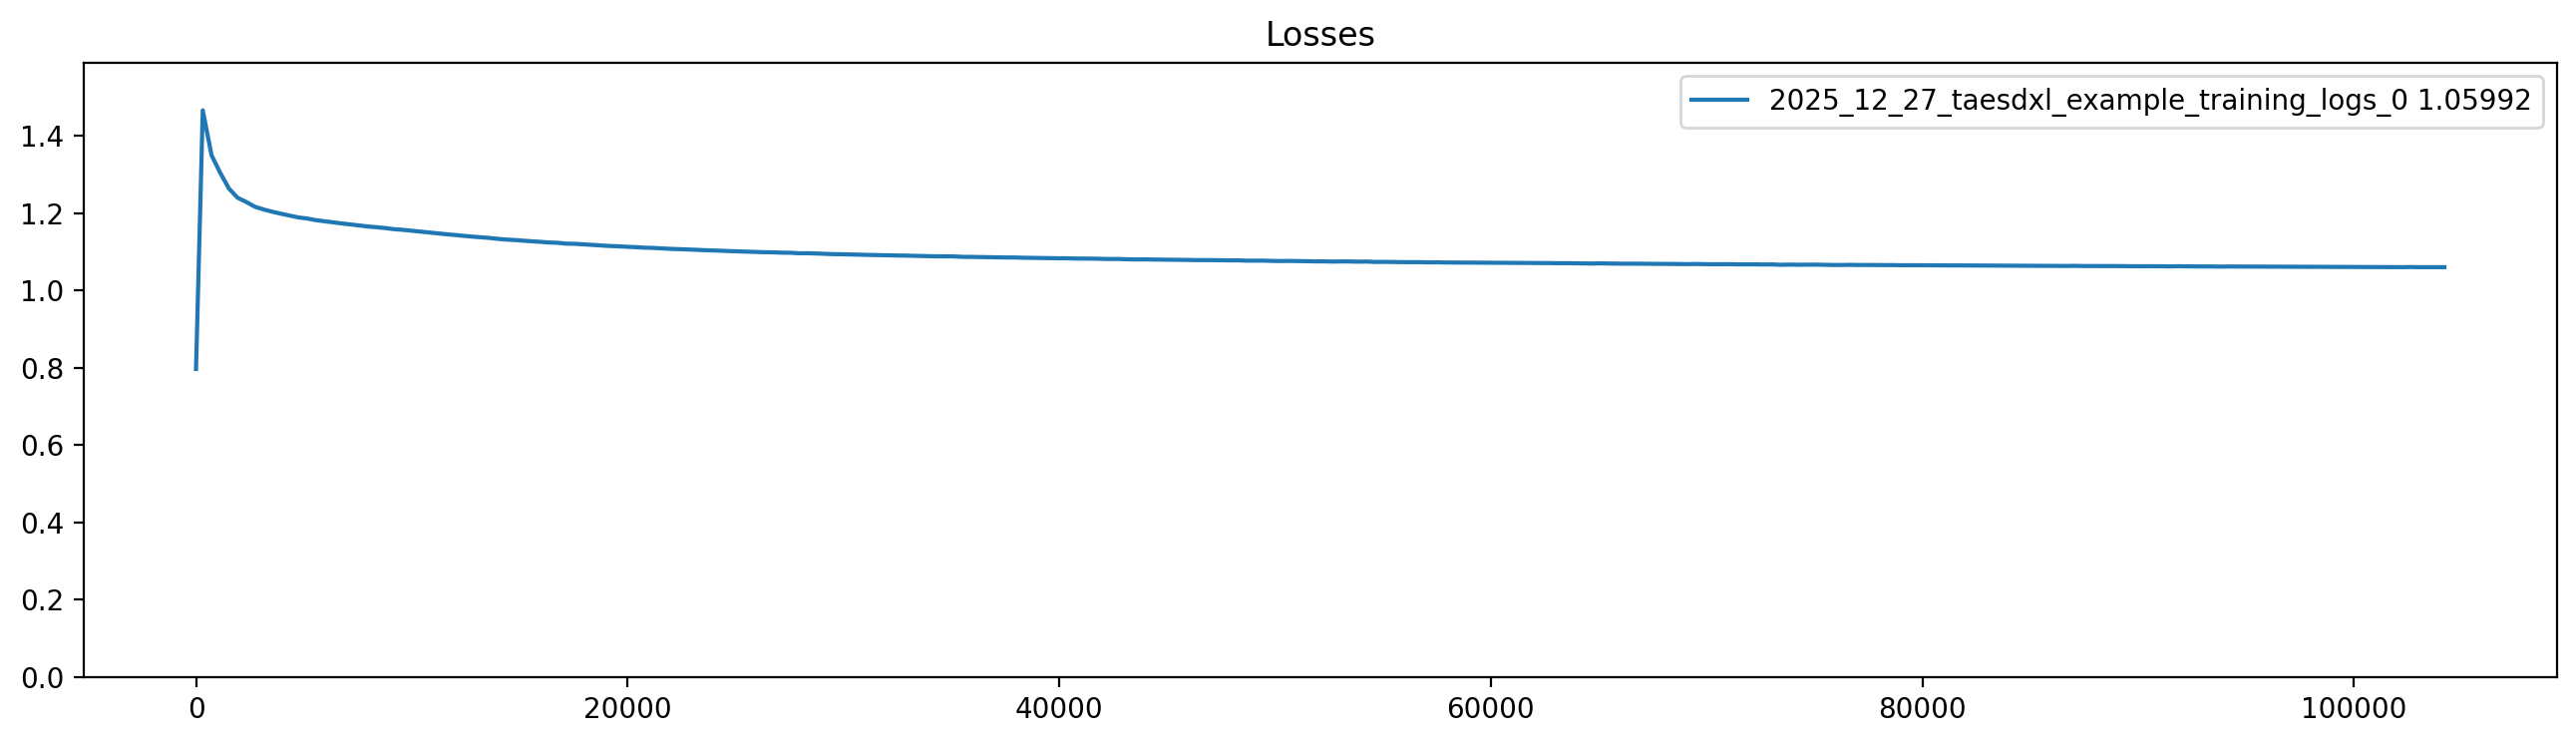

 104260 Steps;  7887 Seconds; 793.0 Steps / Min; 25376.7 Images / Min; Loss 1.05978

KeyboardInterrupt: 

In [15]:
trainer.train(n_seconds=24 * 60 * 60)

In [1]:
import torch
import torch.nn as nn
import copy


def test_gradient_spy():
    # 1. Подготовка данных
    # Простая модель: y = w * x + b
    model_clean = nn.Linear(1, 1)

    # Создаем точную копию модели, чтобы веса были одинаковыми
    model_spy = copy.deepcopy(model_clean)

    # Входные данные и цель
    x = torch.tensor([[1.0]])
    target = torch.tensor([[3.0]])

    print(f"Вход: {x.item()}, Цель: {target.item()}\n")

    # ==========================================
    # Сценарий А: Обычное обучение (без трюков)
    # ==========================================
    pred_clean = model_clean(x)
    loss_clean = (pred_clean - target) ** 2  # MSE Loss
    loss_clean.backward()

    grad_w_clean = model_clean.weight.grad.item()
    print(f"--- Сценарий А (Чистый) ---")
    print(f"Предсказание: {pred_clean.item():.4f}")
    print(f"Градиент веса (dL/dw): {grad_w_clean:.4f}")

    # ==========================================
    # Сценарий Б: С "нулевым градиентом" (трюк из кода)
    # ==========================================
    # Тот самый "шпионский" тензор
    decoder_grad = torch.zeros_like(x, requires_grad=True)

    # output = model(x) + 0
    pred_spy = model_spy(x) + decoder_grad

    loss_spy = (pred_spy - target) ** 2
    loss_spy.backward()

    grad_w_spy = model_spy.weight.grad.item()
    grad_spy_captured = decoder_grad.grad.item()

    print(f"\n--- Сценарий Б (С трюком) ---")
    print(f"Предсказание: {pred_spy.item():.4f}")
    print(f"Градиент веса (dL/dw): {grad_w_spy:.4f}")
    print(f"Перехваченный градиент (decoder_grad): {grad_spy_captured:.4f}")

    # ==========================================
    # ПРОВЕРКА
    # ==========================================
    print(f"\n--- Результаты проверки ---")

    # 1. Влияет ли трюк на обучение весов?
    grads_equal = torch.isclose(model_clean.weight.grad, model_spy.weight.grad)
    print(
        f"1. Градиенты весов совпадают? -> {grads_equal.item()} (TRUE = обучение не сломано)"
    )

    # 2. Что поймал шпион?
    # Математически для MSE: Loss = (y - t)^2 -> dL/dy = 2 * (y - t)
    expected_grad = 2 * (pred_spy.item() - target.item())
    print(f"2. Ожидаемый градиент dL/dy: {expected_grad:.4f}")
    print(f"   Пойманный градиент:       {grad_spy_captured:.4f}")


if __name__ == "__main__":
    test_gradient_spy()

Вход: 1.0, Цель: 3.0

--- Сценарий А (Чистый) ---
Предсказание: 1.0037
Градиент веса (dL/dw): -3.9927

--- Сценарий Б (С трюком) ---
Предсказание: 1.0037
Градиент веса (dL/dw): -3.9927
Перехваченный градиент (decoder_grad): -3.9927

--- Результаты проверки ---
1. Градиенты весов совпадают? -> True (TRUE = обучение не сломано)
2. Ожидаемый градиент dL/dy: -3.9927
   Пойманный градиент:       -3.9927


In [2]:
import torch
import torch.nn as nn


def prove_gradients_vanish():
    print("=== ПРОВЕРКА: Исчезновение промежуточных градиентов ===\n")

    # Простая модель и данные
    model = nn.Linear(1, 1)
    x = torch.tensor([[1.0]])
    target = torch.tensor([[3.0]])

    # ---------------------------------------------------------
    # СЦЕНАРИЙ 1: Обычный (Без сохранения)
    # ---------------------------------------------------------
    print("1. Обычный проход (decoded = model(x)):")

    decoded_normal = model(x)
    loss = (decoded_normal - target) ** 2
    loss.backward()

    # Попытка прочитать градиент выхода
    # ВНИМАНИЕ: Здесь будет предупреждение (UserWarning),
    # а значение будет None, потому что PyTorch удалил этот градиент.
    grad_val = decoded_normal.grad

    if grad_val is None:
        print("   -> decoded.grad is None! (Градиент был удален для экономии памяти)")
    else:
        print(f"   -> decoded.grad: {grad_val}")

    # ---------------------------------------------------------
    # СЦЕНАРИЙ 2: С твоим трюком (decoder_grad)
    # ---------------------------------------------------------
    print("\n2. Проход с трюком (decoded = model(x) + spy):")

    # Сбрасываем модель
    model.zero_grad()

    # Создаем "шпиона" - листовой тензор
    decoder_grad_spy = torch.zeros_like(x, requires_grad=True)

    # Внедряем его
    decoded_with_spy = model(x) + decoder_grad_spy

    loss = (decoded_with_spy - target) ** 2
    loss.backward()

    # Проверяем шпиона
    grad_val_spy = decoder_grad_spy.grad

    if grad_val_spy is None:
        print("   -> spy.grad is None!")
    else:
        print(f"   -> spy.grad: {grad_val_spy.item()} (Градиент успешно пойман!)")

    # Доп. проверка: сами выходы декодера по-прежнему не хранят градиент
    # print(f"   -> Само decoded_with_spy.grad: {decoded_with_spy.grad}") # Тоже будет None


if __name__ == "__main__":
    prove_gradients_vanish()

=== ПРОВЕРКА: Исчезновение промежуточных градиентов ===

1. Обычный проход (decoded = model(x)):
   -> decoded.grad is None! (Градиент был удален для экономии памяти)

2. Проход с трюком (decoded = model(x) + spy):
   -> spy.grad: -5.461555480957031 (Градиент успешно пойман!)


/tmp/ipykernel_1758374/488506796.py:25: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_val = decoded_normal.grad
